# torch.compile performance uplift validation
The following trainer validation, is used to compare performance differences between the following optimizations

- torch native
- torch + JIT
- torch + torch.compile

To simplify the benchmarking, we are intentionally only performing
- L16-D2048 (modified 1B5 to fit into 24GB vram DS1)
- training ctxlen = 1024
- data ctxlen = 4096
- 100 trainer/global_step
- 10 gradient accumulation (per GPU)
- no checkpoint save to disk (reduce the influence of random diskio in timings)

This would (on a single GPU) perform the run over
- a 1000 data samples

The following experiments were executed on a single `a10g` gpu `g5.8xlarge` AWS instance for consistency. With `deepspeed_stage_1`

## Ensure your conda env is updated

Torch compile is new after all

## Configure and apply your preferred settings

Adjust your desired deepspeed settings, and gpu device count.
Enable/Disable WANDB here as well (recommended disabled, to reduce perf impact)

( note you will need to rerun this cell, if you restart your env )

In [49]:
DEEPSPEED_STRAT="deepspeed_stage_1"
GPU_DEVICES="auto"
ENABLE_WANDB=False

print("DEEPSPEED_STRAT:", DEEPSPEED_STRAT)
print("ENABLE_WANDB:", ENABLE_WANDB)
print("GPU_DEVICES:", GPU_DEVICES)

if ENABLE_WANDB:
    WANDB_MODE="online"
else:
    WANDB_MODE="disabled"

# Model sizing control
MODEL_LAYERS=12
MODEL_DIMS=2048

# Ensure logs dir is initialized, required for data crunching
!mkdir -p ./logs/

# Computing the notebook, and various paths
import os
NOTEBOOK_DIR=os.path.dirname(os.path.abspath("__file__"))
PROJECT_DIR=os.path.abspath(os.path.join(NOTEBOOK_DIR, "../../"))
TRAINER_DIR=os.path.abspath(os.path.join(PROJECT_DIR, "./RWKV-v5/"))

print("NOTEBOOK_DIR:", NOTEBOOK_DIR)
print("TRAINER_DIR:", TRAINER_DIR)
print("PROJECT_DIR:", PROJECT_DIR)

DEEPSPEED_STRAT: deepspeed_stage_1
ENABLE_WANDB: False
GPU_DEVICES: auto
NOTEBOOK_DIR: /home/picocreator/rwkv-proj/RWKV-infctx-trainer/notebook/trainer-v5-validation
TRAINER_DIR: /home/picocreator/rwkv-proj/RWKV-infctx-trainer/RWKV-v5
PROJECT_DIR: /home/picocreator/rwkv-proj/RWKV-infctx-trainer


## Preload your data / model
The data has minor differences from baseline, and needs to be preloaded here

In [15]:
# Lets preload the requried dataset 
!cd "{TRAINER_DIR}" && \
    python3 preload_datapath.py "{NOTEBOOK_DIR}/config/torch-compile-perf.yaml"

Map (num_proc=16): 100%|███████████| 1307/1307 [00:00<00:00, 3397.28 examples/s]
Saving the dataset (1/1 shards): 100%|█| 1307/1307 [00:00<00:00, 28006.74 exampl
Saving the dataset (1/1 shards): 100%|█| 14/14 [00:00<00:00, 7056.87 examples/s]


In [28]:
# Lets initialized the L12-D768 model with the init_model.py code
!cd "{TRAINER_DIR}" && python3 init_model.py \
    --n_layer {MODEL_LAYERS} --n_embd {MODEL_DIMS} \
    --vocab_size world \
    --skip-if-exists --safe-init \
    ../model/L{MODEL_LAYERS}-D{MODEL_DIMS}-world-v5-init.pth

[2024-01-19 05:16:52,254] [INFO] [real_accelerator.py:161:get_accelerator] Setting ds_accelerator to cuda (auto detect)
[RWKV.model] Running RWKV model using 'torch-jit' with torch '2.1.2'
---- Initializing model ----
No of layers: 12
Embedding size: 2048
Output model path: ../model/L12-D2048-world-v5-init.pth
Vocab size: 65536
Emb scale: 0.0001
Note: this process takes a significant time (and ram) for large models
---- ----- ----
---
[RWKV.TimeMix] Compiling CUDA kernel with HEAD_SIZE=64
Using /home/picocreator/.cache/torch_extensions/py311_cu121 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/picocreator/.cache/torch_extensions/py311_cu121/wkv5/build.ninja...
Building extension module wkv5...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
ninja: no work to do.
Loading extension module wkv5...
[RWKV.TimeMix] CUDA kernel compiled & loaded globally
---
65536 2048  -0.00

## Perform baseline benchmark (no JIT / no toch compile)

In [29]:
!cd "{TRAINER_DIR}" && \
    touch "{NOTEBOOK_DIR}/logs/torch-compile-perf_baseline.log" && \
    export RWKV_TORCH_COMPILE=0 && \
    export RWKV_JIT_ON=0 && \
    export WANDB_MODE="{WANDB_MODE}" && \
    python3 lightning_trainer.py fit \
        -c "{NOTEBOOK_DIR}/config/torch-compile-perf.yaml" \
        --model.load_model="../model/L{MODEL_LAYERS}-D{MODEL_DIMS}-world-v5-init.pth" \
        --trainer.logger.init_args.name="infctx-torch-compile-perf (no JIT / no torch compile)" \
        --trainer.strategy="{DEEPSPEED_STRAT}" \
        --trainer.devices="{GPU_DEVICES}" \
    | tee "{NOTEBOOK_DIR}/logs/torch-compile-perf_baseline.log"

[2024-01-19 05:17:24,398] [INFO] [real_accelerator.py:161:get_accelerator] Setting ds_accelerator to cuda (auto detect)
[RWKV.model] Running RWKV model using 'torch-native' with torch '2.1.2'
/home/picocreator/anaconda3/envs/rwkv-infctx/lib/python3.11/site-packages/lightning/pytorch/cli.py:518: LightningCLI's args parameter is intended to run from within Python like if it were from the command line. To prevent mistakes it is not recommended to provide both args and command line arguments, got: sys.argv[1:]=['fit', '-c', '/home/picocreator/rwkv-proj/RWKV-infctx-trainer/notebook/trainer-v5-validation/config/torch-compile-perf.yaml', '--model.load_model=../model/L12-D2048-world-v5-init.pth', '--trainer.logger.init_args.name=infctx-torch-compile-perf (no JIT / no torch compile)', '--trainer.strategy=deepspeed_stage_1', '--trainer.devices=auto'], args=['fit', '-c', '/home/picocreator/rwkv-proj/RWKV-infctx-trainer/notebook/trainer-v5-validation/config/torch-compile-perf.yaml', '--model.load_

## Perform JIT benchmark

In [30]:
!cd "{TRAINER_DIR}" && \
    touch "{NOTEBOOK_DIR}/logs/torch-compile-perf_jit.log" && \
    export RWKV_TORCH_COMPILE=0 && \
    export RWKV_JIT_ON=1 && \
    export WANDB_MODE="{WANDB_MODE}" && \
    python3 lightning_trainer.py fit \
        -c "{NOTEBOOK_DIR}/config/torch-compile-perf.yaml" \
        --model.load_model="../model/L{MODEL_LAYERS}-D{MODEL_DIMS}-world-v5-init.pth" \
        --trainer.logger.init_args.name="infctx-torch-compile-perf ( with JIT )" \
        --trainer.strategy="{DEEPSPEED_STRAT}" \
        --trainer.devices="{GPU_DEVICES}" \
    | tee "{NOTEBOOK_DIR}/logs/torch-compile-perf_jit.log"

[2024-01-19 05:27:52,442] [INFO] [real_accelerator.py:161:get_accelerator] Setting ds_accelerator to cuda (auto detect)
[RWKV.model] Running RWKV model using 'torch-jit' with torch '2.1.2'
/home/picocreator/anaconda3/envs/rwkv-infctx/lib/python3.11/site-packages/lightning/pytorch/cli.py:518: LightningCLI's args parameter is intended to run from within Python like if it were from the command line. To prevent mistakes it is not recommended to provide both args and command line arguments, got: sys.argv[1:]=['fit', '-c', '/home/picocreator/rwkv-proj/RWKV-infctx-trainer/notebook/trainer-v5-validation/config/torch-compile-perf.yaml', '--model.load_model=../model/L12-D2048-world-v5-init.pth', '--trainer.logger.init_args.name=infctx-torch-compile-perf ( with JIT )', '--trainer.strategy=deepspeed_stage_1', '--trainer.devices=auto'], args=['fit', '-c', '/home/picocreator/rwkv-proj/RWKV-infctx-trainer/notebook/trainer-v5-validation/config/torch-compile-perf.yaml', '--model.load_model=../model/L12

## Perform Torch.compile benchmark

Reminder: You will need either pytorch nightly OR pytorch 2.1.0

In [54]:
!cd "{TRAINER_DIR}" && \
    touch "{NOTEBOOK_DIR}/logs/torch-compile-perf_torch-compile.log" && \
    export RWKV_TORCH_COMPILE=1 && \
    export RWKV_JIT_ON=0 && \
    export WANDB_MODE="{WANDB_MODE}" && \
    python3 lightning_trainer.py fit \
        -c "{NOTEBOOK_DIR}/config/torch-compile-perf.yaml" \
        --model.load_model="../model/L{MODEL_LAYERS}-D{MODEL_DIMS}-world-v5-init.pth" \
        --trainer.logger.init_args.name="infctx-torch-compile-perf ( with torch.compile )" \
        --trainer.strategy="{DEEPSPEED_STRAT}" \
        --trainer.devices="{GPU_DEVICES}" \
    | tee "{NOTEBOOK_DIR}/logs/torch-compile-perf_torch-compile.log"

    # export TORCH_LOGS="+dynamo" && \
    # export TORCHDYNAMO_VERBOSE=1 && \

/bin/bash: -c: line 1: syntax error: unexpected end of file


# Lets compare the numbers!

Because we are not using WANDB for this benchmark, lets crunch the logs for the numbers we need!

In [ ]:
# Install matlab plotting library
!python3 -m pip install matplotlib

In [7]:
# First we need to extract the numbers from the logs
import re

def convert_time_to_seconds(time_str):
    t = list(map(int, time_str.split(':')))
    return sum([a*b for (a,b) in zip(t[::-1], (1, 60, 3600))])

def extract_from_training_logs(log_file):
    result = []
    with open(log_file, 'r') as file:
        for line in file.readlines():
            # Check if the line starts with "Epoch 0:"
            if line.startswith("Epoch 0:"):
                iteration = re.search(r'(?<=\| )(\d+)', line)   # Extracts the iteration number
                time_spent = re.search(r'(?<=\[)(.*?)(?=<)', line)    # Extracts the time spent so far
                loss = re.search(r'(?<=train/loss=)(\d+.\d+)', line)  # Extracts the train/loss number
      
                if iteration and time_spent and loss:
                    result.append({
                        "it": int(iteration.group(0)), 
                        "time": convert_time_to_seconds(time_spent.group(0)),
                        "s_time": time_spent.group(0),
                        "loss": float(loss.group(0))
                    })
    return result


# Extract the numbers
step_baseline = extract_from_training_logs("./logs/torch-compile-perf_baseline.log")
step_jit = extract_from_training_logs("./logs/torch-compile-perf_jit.log")
step_tcompile = extract_from_training_logs("./logs/torch-compile-perf_torch-compile.log")

# Print the high level numbers (quick debugging, if log has issues)
print("First step figures ...")
print("Baseline: ", step_baseline[0])
print("JIT: ", step_jit[0])
print("Torch Compile: ", step_tcompile[0])
print("")
print("First 200 step figures ...")
print("Baseline: ", step_baseline[200])
print("JIT: ", step_jit[200])
print("Torch Compile: ", step_tcompile[200])
print("")
print("Last step figures ...")
print("Baseline: ", step_baseline[-1])
print("JIT: ", step_jit[-1])
print("Torch Compile: ", step_tcompile[-1])


First step figures ...
Baseline:  {'it': 1, 'time': 9, 's_time': '00:09', 'loss': 10.9}
JIT:  {'it': 1, 'time': 13, 's_time': '00:13', 'loss': 10.9}
Torch Compile:  {'it': 1, 'time': 72, 's_time': '01:12', 'loss': 10.9}

First 200 step figures ...
Baseline:  {'it': 101, 'time': 175, 's_time': '02:55', 'loss': 8.38}
JIT:  {'it': 101, 'time': 172, 's_time': '02:52', 'loss': 8.38}
Torch Compile:  {'it': 101, 'time': 225, 's_time': '03:45', 'loss': 8.38}

Last step figures ...
Baseline:  {'it': 1000, 'time': 1464, 's_time': '24:24', 'loss': 6.62}
JIT:  {'it': 1000, 'time': 1407, 's_time': '23:27', 'loss': 6.66}
Torch Compile:  {'it': 1000, 'time': 1399, 's_time': '23:19', 'loss': 6.66}


# Check if the loss plot is similar

No point having a faster JIT / torch.compile, if the loss curve does not fall at the same rate

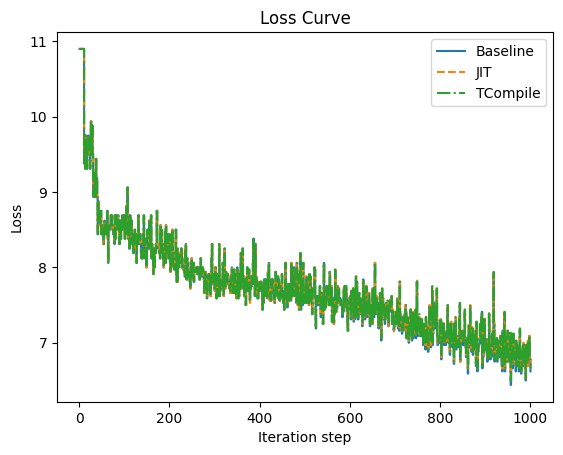

In [8]:
# Plot the loss curve
import matplotlib.pyplot as plt

# Extract iteration and loss values for each method
it_baseline = [entry['it'] for entry in step_baseline]
loss_baseline = [entry['loss'] for entry in step_baseline]

it_jit = [entry['it'] for entry in step_jit]
loss_jit = [entry['loss'] for entry in step_jit]

it_tcompile = [entry['it'] for entry in step_tcompile]
loss_tcompile = [entry['loss'] for entry in step_tcompile]

# Plot loss curves
plt.plot(it_baseline, loss_baseline, label="Baseline", linestyle='-')
plt.plot(it_jit, loss_jit, label="JIT", linestyle='--')
plt.plot(it_tcompile, loss_tcompile, label="TCompile", linestyle='-.')

plt.xlabel('Iteration step')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.show()

If everything is working as designed, it should be nearly impossible to see the differences between the 3 lines. So lets plot the delta against baseline instead.

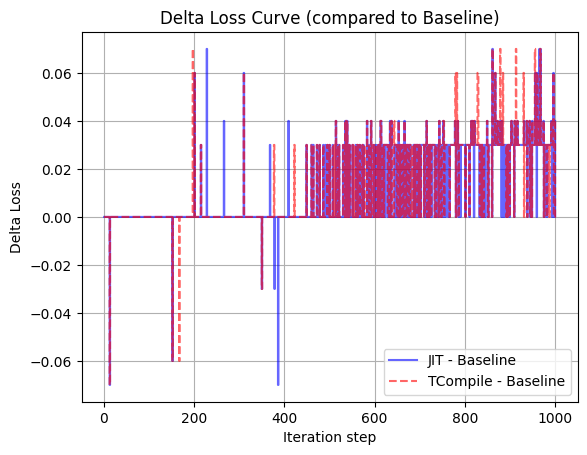

In [9]:
import numpy as np

# Convert lists to numpy arrays for easier manipulation
loss_baseline_np = np.array(loss_baseline)
loss_jit_np = np.array(loss_jit)
loss_tcompile_np = np.array(loss_tcompile)

# Calculate deltas
delta_jit_baseline = (loss_jit_np - loss_baseline_np)
delta_tcompile_baseline = (loss_tcompile_np - loss_baseline_np)

# Plot deltas
plt.plot(it_jit, delta_jit_baseline, label="JIT - Baseline", linestyle='-', color='blue', alpha=0.6)
plt.plot(it_tcompile, delta_tcompile_baseline, label="TCompile - Baseline", linestyle='--', color='red', alpha=0.6)

plt.xlabel('Iteration step')
plt.ylabel('Delta Loss')
plt.title('Delta Loss Curve (compared to Baseline)')
plt.legend()
plt.grid(True)
plt.show()

If everything is working as per designed, the differences between "Delta Loss" should be within margin of error, of run-by-run varience

# Plot the time charts!

Lets start with a basic iteration step over cummulative time

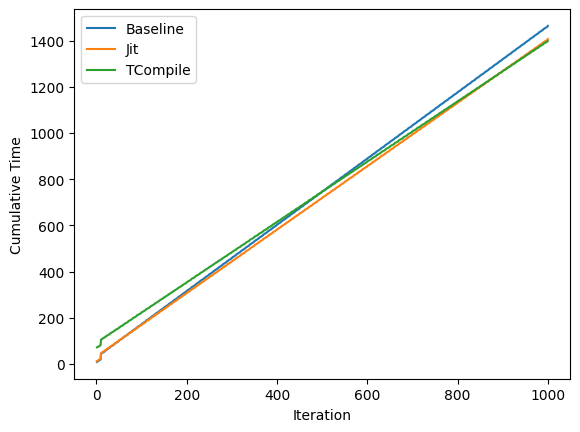

In [10]:
import matplotlib.pyplot as plt

# Extract the 'it' and 'time' values from each dictionary in each list
it_baseline = [x['it'] for x in step_baseline]
time_baseline = [x['time'] for x in step_baseline]

it_jit = [x['it'] for x in step_jit]
time_jit = [x['time'] for x in step_jit]

it_tcompile = [x['it'] for x in step_tcompile]
time_tcompile = [x['time'] for x in step_tcompile]

# Plot cumulative time for each iteration
plt.plot(it_baseline, time_baseline, label='Baseline')
plt.plot(it_jit, time_jit, label='Jit')
plt.plot(it_tcompile, time_tcompile, label='TCompile')

# Label the axes
plt.xlabel('Iteration')
plt.ylabel('Cumulative Time')

# Add a legend
plt.legend(loc='upper left')

# Display the plot
plt.show()

If everything is working correctly it should show that

- baseline: lowest starting time, highest accumulative rate
- JIT: similar starting time, lower accumulative rate
- TCompile: slowest starting time, lowest accumulative rate

This can be observed by getting the average time per iteration for the first 200 steps and the following 2 x 400 steps

In [11]:
# Compute the average time for the first `n` iterations and for the rest
def compute_average_time_delta(data, start, end):
    time = [x['time'] for x in data]
    if start == -1:
        return (time[end-1]) / (end)
    else:
        return (time[end-1] - time[start]) / (end - start)

# PS, [0] pos shows the timing for the first step, so we use -1 to start from "0"
first_R = 200
first_R_baseline = compute_average_time_delta(step_baseline, -1, first_R)
first_R_jit      = compute_average_time_delta(step_jit,      -1, first_R)
first_R_tcompile = compute_average_time_delta(step_tcompile, -1, first_R)

next_W = 400
next_W_baseline = compute_average_time_delta(step_baseline, first_R, first_R + next_W)
next_W_jit      = compute_average_time_delta(step_jit,      first_R, first_R + next_W)
next_W_tcompile = compute_average_time_delta(step_tcompile, first_R, first_R + next_W)

next_K = 400
next_K_baseline = compute_average_time_delta(step_baseline, first_R + next_W, first_R + next_W + next_K)
next_K_jit      = compute_average_time_delta(step_jit,      first_R + next_W, first_R + next_W + next_K)
next_K_tcompile = compute_average_time_delta(step_tcompile, first_R + next_W, first_R + next_W + next_K)

print(f"Average delta time for the first {first_R} iterations ('warmup'):")
print(f"Baseline: {first_R_baseline * 1000} ms")
print(f"Jit:      {first_R_jit * 1000} ms")
print(f"TCompile: {first_R_tcompile * 1000} ms")
print("")

print(f"Average delta time after 'warmup' for {next_W} iterations:")
print(f"Baseline: {next_W_baseline * 1000} ms")
print(f"Jit:      {next_W_jit * 1000} ms")
print(f"TCompile: {next_W_tcompile * 1000} ms")
print("")

print(f"Average delta time for last {next_K} iterations:")
print(f"Baseline: {next_K_baseline * 1000} ms")
print(f"Jit:      {next_K_jit * 1000} ms")
print(f"TCompile: {next_K_tcompile * 1000} ms")


Average delta time for the first 200 iterations ('warmup'):
Baseline: 875.0 ms
Jit:      860.0 ms
TCompile: 1125.0 ms

Average delta time after 'warmup' for 400 iterations:
Baseline: 715.0 ms
Jit:      685.0 ms
TCompile: 652.5 ms

Average delta time for last 400 iterations:
Baseline: 717.5 ms
Jit:      687.5 ms
TCompile: 655.0 ms
